In [ ]:
import torch
# For windows/linux will try CUDA first, then CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#set default device for following code, so we don't need to specify device every time
torch.set_default_device(device)

cuda


load resale data

In [ ]:
import pandas as pd
#file_path = r"C:\content\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv"
df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

# Display basic info
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                202109 non-null  object 
 1   town                 202109 non-null  object 
 2   flat_type            202109 non-null  object 
 3   block                202109 non-null  object 
 4   street_name          202109 non-null  object 
 5   storey_range         202109 non-null  object 
 6   floor_area_sqm       202109 non-null  float64
 7   flat_model           202109 non-null  object 
 8   lease_commence_date  202109 non-null  int64  
 9   remaining_lease      202109 non-null  object 
 10  resale_price         202109 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 17.0+ MB


(None,
      month        town flat_type block        street_name storey_range  \
 0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
 1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
 2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
 3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
 4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
 
    floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
 0            44.0        Improved                 1979  61 years 04 months   
 1            67.0  New Generation                 1978  60 years 07 months   
 2            67.0  New Generation                 1980  62 years 05 months   
 3            68.0  New Generation                 1980   62 years 01 month   
 4            67.0  New Generation                 1980  62 years 05 months   
 
    resale_price  
 0      232000.0  
 1      250000.0  
 2      

clean resale data

In [ ]:
import numpy as np

# Convert 'month' to datetime format
df['month'] = pd.to_datetime(df['month'])

df['year'] = df['month'].dt.year.astype(int)

# Extract midpoint of storey range
def extract_storey_midpoint(storey_range):
    """Convert storey range (e.g., '04 TO 06') into a single approximate storey number."""
    range_values = storey_range.split(" TO ")
    if len(range_values) == 2:
        return (int(range_values[0]) + int(range_values[1])) / 2
    return int(range_values[0])  # In case of a single value

df['storey_mid'] = df['storey_range'].apply(extract_storey_midpoint)

# Convert 'remaining_lease' to numerical format (years)
def convert_remaining_lease(lease_str):
    """Extracts total lease years from 'XX years YY months'."""
    parts = lease_str.split(" ")
    years = int(parts[0])  # Extract the years part
    months = int(parts[2]) if "months" in lease_str else 0  # Extract months if available
    return years + (months / 12)  # Convert months to fraction of a year

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_remaining_lease)

# Combine block and streetname
df['Search Name'] = df['block'] + ' ' + df['street_name']

# Drop unnecessary columns
df_cleaned = df.drop(columns=['block', 'street_name', 'storey_range', 'remaining_lease'])

# Show cleaned data info
df_cleaned.info(), df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   month                  202109 non-null  datetime64[ns]
 1   town                   202109 non-null  object        
 2   flat_type              202109 non-null  object        
 3   floor_area_sqm         202109 non-null  float64       
 4   flat_model             202109 non-null  object        
 5   lease_commence_date    202109 non-null  int64         
 6   resale_price           202109 non-null  float64       
 7   year                   202109 non-null  int64         
 8   storey_mid             202109 non-null  float64       
 9   remaining_lease_years  202109 non-null  float64       
 10  Search Name            202109 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 17.0+ MB


(None,
        month        town flat_type  floor_area_sqm      flat_model  \
 0 2017-01-01  ANG MO KIO    2 ROOM            44.0        Improved   
 1 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 2 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 3 2017-01-01  ANG MO KIO    3 ROOM            68.0  New Generation   
 4 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 
    lease_commence_date  resale_price  year  storey_mid  remaining_lease_years  \
 0                 1979      232000.0  2017        11.0              61.333333   
 1                 1978      250000.0  2017         2.0              60.583333   
 2                 1980      262000.0  2017         2.0              62.416667   
 3                 1980      265000.0  2017         5.0              62.000000   
 4                 1980      265000.0  2017         2.0              62.416667   
 
              Search Name  
 0  406 ANG MO KIO AVE 10  
 1   108 ANG MO

load amenities data

In [ ]:
df_amenities = pd.read_csv("address_data_full.csv")
# Display basic info
df_amenities.info(), df_amenities.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9629 entries, 0 to 9628
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Search Name            9629 non-null   object 
 1   Address                9629 non-null   object 
 2   Address Lat            9629 non-null   float64
 3   Address Long           9629 non-null   float64
 4   Nearest MRT Station    9629 non-null   object 
 5   Nearest MRT Distance   9629 non-null   float64
 6   Nearest Mall Name      9629 non-null   object 
 7   Nearest Mall Distance  9629 non-null   float64
 8   Nearest NPC            9629 non-null   object 
 9   Nearest NPC Distance   9629 non-null   float64
dtypes: float64(5), object(5)
memory usage: 752.4+ KB


(None,
              Search Name                   Address  Address Lat  Address Long  \
 0  406 ANG MO KIO AVE 10  406 ANG MO KIO AVENUE 10     1.362005    103.853880   
 1   108 ANG MO KIO AVE 4   108 ANG MO KIO AVENUE 4     1.370966    103.838202   
 2   602 ANG MO KIO AVE 5   602 ANG MO KIO AVENUE 5     1.380709    103.835368   
 3  465 ANG MO KIO AVE 10  465 ANG MO KIO AVENUE 10     1.366201    103.857201   
 4   601 ANG MO KIO AVE 5   601 ANG MO KIO AVENUE 5     1.381041    103.835132   
 
              Nearest MRT Station  Nearest MRT Distance  \
 0  ANG MO KIO MRT STATION (NS16)              1.003997   
 1    MAYFLOWER MRT STATION (TE6)              0.189875   
 2       LENTOR MRT STATION (TE5)              0.535117   
 3  ANG MO KIO MRT STATION (NS16)              0.945529   
 4       LENTOR MRT STATION (TE5)              0.501152   
 
                Nearest Mall Name  Nearest Mall Distance  \
 0                        AMK HUB               1.017286   
 1                     

merge resale and amenities

In [ ]:
df_resale_amenities = pd.merge(df_cleaned, df_amenities, on='Search Name', how='left')

# Show cleaned data info
df_resale_amenities.info(), df_resale_amenities.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   month                  202109 non-null  datetime64[ns]
 1   town                   202109 non-null  object        
 2   flat_type              202109 non-null  object        
 3   floor_area_sqm         202109 non-null  float64       
 4   flat_model             202109 non-null  object        
 5   lease_commence_date    202109 non-null  int64         
 6   resale_price           202109 non-null  float64       
 7   year                   202109 non-null  int64         
 8   storey_mid             202109 non-null  float64       
 9   remaining_lease_years  202109 non-null  float64       
 10  Search Name            202109 non-null  object        
 11  Address                202109 non-null  object        
 12  Address Lat            202109 non-null  floa

(None,
        month        town flat_type  floor_area_sqm      flat_model  \
 0 2017-01-01  ANG MO KIO    2 ROOM            44.0        Improved   
 1 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 2 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 3 2017-01-01  ANG MO KIO    3 ROOM            68.0  New Generation   
 4 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 
    lease_commence_date  resale_price  year  storey_mid  remaining_lease_years  \
 0                 1979      232000.0  2017        11.0              61.333333   
 1                 1978      250000.0  2017         2.0              60.583333   
 2                 1980      262000.0  2017         2.0              62.416667   
 3                 1980      265000.0  2017         5.0              62.000000   
 4                 1980      265000.0  2017         2.0              62.416667   
 
              Search Name                   Address  Address Lat  Addre

rename columns

In [ ]:
df_resale_amenities.drop(columns=['Address'], inplace=True)
df_resale_amenities.rename(columns={'Search Name': 'Address'}, inplace=True)
# Show cleaned data info
df_resale_amenities.info(), df_resale_amenities.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   month                  202109 non-null  datetime64[ns]
 1   town                   202109 non-null  object        
 2   flat_type              202109 non-null  object        
 3   floor_area_sqm         202109 non-null  float64       
 4   flat_model             202109 non-null  object        
 5   lease_commence_date    202109 non-null  int64         
 6   resale_price           202109 non-null  float64       
 7   year                   202109 non-null  int64         
 8   storey_mid             202109 non-null  float64       
 9   remaining_lease_years  202109 non-null  float64       
 10  Address                202109 non-null  object        
 11  Address Lat            202109 non-null  float64       
 12  Address Long           202109 non-null  floa

(None,
        month        town flat_type  floor_area_sqm      flat_model  \
 0 2017-01-01  ANG MO KIO    2 ROOM            44.0        Improved   
 1 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 2 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 3 2017-01-01  ANG MO KIO    3 ROOM            68.0  New Generation   
 4 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 
    lease_commence_date  resale_price  year  storey_mid  remaining_lease_years  \
 0                 1979      232000.0  2017        11.0              61.333333   
 1                 1978      250000.0  2017         2.0              60.583333   
 2                 1980      262000.0  2017         2.0              62.416667   
 3                 1980      265000.0  2017         5.0              62.000000   
 4                 1980      265000.0  2017         2.0              62.416667   
 
                  Address  Address Lat  Address Long  \
 0  406 ANG MO 

load inflation data

In [ ]:
import pandas as pd

# Step 1: Load the raw CSV file without skipping rows
raw_cpi = pd.read_csv("M213751 (1).csv", header=None)

# Step 2: Extract headers from row 10 and data from row 11
headers = raw_cpi.iloc[10].tolist()
cpi_values = raw_cpi.iloc[11].tolist()

# Step 3: Clean headers
headers_cleaned = [str(h).strip() for h in headers]

# Step 4: Remove the first non-date header ("Data Series") and align CPI values
valid_months = headers_cleaned[1:]                    # Remove "Data Series"
valid_cpis = cpi_values[1:1 + len(valid_months)]      # Align CPI values

# Step 5: Build clean DataFrame
cpi_df_cleaned = pd.DataFrame({
    'month': valid_months,
    'cpi': valid_cpis
})

# Step 6: Convert types
cpi_df_cleaned['month'] = pd.to_datetime(cpi_df_cleaned['month'], format='%Y %b', errors='coerce')
cpi_df_cleaned['cpi'] = pd.to_numeric(cpi_df_cleaned['cpi'], errors='coerce')

# Step 7: Drop any invalid rows
cpi_df_cleaned = cpi_df_cleaned.dropna(subset=['month', 'cpi'])

# Final CPI output
print(cpi_df_cleaned.head())


       month      cpi
0 2025-02-01  100.677
1 2025-01-01   99.908
2 2024-12-01  100.661
3 2024-11-01  100.387
4 2024-10-01  100.119


In [ ]:
# STEP 1: Ensure 'month' column in HDB dataset is datetime
df_resale_amenities['month'] = pd.to_datetime(df_resale_amenities['month'])

# STEP 2: Merge CPI data on 'month'
df_merged = pd.merge(df_resale_amenities, cpi_df_cleaned, on='month', how='left')

# STEP 3: Inspect merged result
print(df_merged[['month', 'resale_price', 'cpi']].head())


       month  resale_price     cpi
0 2017-01-01      232000.0  85.102
1 2017-01-01      250000.0  85.102
2 2017-01-01      262000.0  85.102
3 2017-01-01      265000.0  85.102
4 2017-01-01      265000.0  85.102


In [ ]:
# Use latest CPI as the base (assumed to be Feb 2025 or Jan 2024)
base_cpi = cpi_df_cleaned['cpi'].iloc[0]  # or .max() if you prefer

# Create inflation-adjusted price column
df_merged['resale_price_real'] = df_merged['resale_price'] * (base_cpi / df_merged['cpi'])

# Preview adjusted prices
df_merged[['resale_price', 'cpi', 'resale_price_real']].head()

,resale_price,cpi,resale_price_real
0,232000.0,85.102,274459.636671
1,250000.0,85.102,295753.918827
2,262000.0,85.102,309950.106931
3,265000.0,85.102,313499.153956
4,265000.0,85.102,313499.153956


In [ ]:
df_merged.info(), df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   month                  202109 non-null  datetime64[ns]
 1   town                   202109 non-null  object        
 2   flat_type              202109 non-null  object        
 3   floor_area_sqm         202109 non-null  float64       
 4   flat_model             202109 non-null  object        
 5   lease_commence_date    202109 non-null  int64         
 6   resale_price           202109 non-null  float64       
 7   year                   202109 non-null  int64         
 8   storey_mid             202109 non-null  float64       
 9   remaining_lease_years  202109 non-null  float64       
 10  Address                202109 non-null  object        
 11  Address Lat            202109 non-null  float64       
 12  Address Long           202109 non-null  floa

(None,
        month        town flat_type  floor_area_sqm      flat_model  \
 0 2017-01-01  ANG MO KIO    2 ROOM            44.0        Improved   
 1 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 2 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 3 2017-01-01  ANG MO KIO    3 ROOM            68.0  New Generation   
 4 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 
    lease_commence_date  resale_price  year  storey_mid  remaining_lease_years  \
 0                 1979      232000.0  2017        11.0              61.333333   
 1                 1978      250000.0  2017         2.0              60.583333   
 2                 1980      262000.0  2017         2.0              62.416667   
 3                 1980      265000.0  2017         5.0              62.000000   
 4                 1980      265000.0  2017         2.0              62.416667   
 
    ... Address Lat  Address Long            Nearest MRT Station  \
 0 

In [ ]:
df_merged.to_csv('df_merged.csv', index=False)

In [ ]:
df_merged = pd.read_csv("df_merged.csv")
print((df_merged.isna().all(axis=1)).sum())

704


In [ ]:
df_merged = df_merged.dropna(how='all')  # This removes rows where *all* values are NaN
df_merged.to_csv('df_merged2.csv', index=False)

Start

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_merged = pd.read_csv("df_merged.csv")
df_merged.info(), df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201405 entries, 0 to 201404
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   month                  201405 non-null  object 
 1   town                   201405 non-null  object 
 2   flat_type              201405 non-null  object 
 3   floor_area_sqm         201405 non-null  float64
 4   flat_model             201405 non-null  object 
 5   lease_commence_date    201405 non-null  float64
 6   resale_price           201405 non-null  float64
 7   year                   201405 non-null  float64
 8   storey_mid             201405 non-null  float64
 9   remaining_lease_years  201405 non-null  float64
 10  Address                201405 non-null  object 
 11  Address Lat            201405 non-null  float64
 12  Address Long           201405 non-null  float64
 13  Nearest MRT Station    201405 non-null  object 
 14  Nearest MRT Distance   201405 non-nu

(None,
       month        town flat_type  floor_area_sqm      flat_model  \
 0  1/1/2017  ANG MO KIO    2 ROOM            44.0        Improved   
 1  1/1/2017  ANG MO KIO    3 ROOM            67.0  New Generation   
 2  1/1/2017  ANG MO KIO    3 ROOM            67.0  New Generation   
 3  1/1/2017  ANG MO KIO    3 ROOM            68.0  New Generation   
 4  1/1/2017  ANG MO KIO    3 ROOM            67.0  New Generation   
 
    lease_commence_date  resale_price    year  storey_mid  \
 0               1979.0      232000.0  2017.0        11.0   
 1               1978.0      250000.0  2017.0         2.0   
 2               1980.0      262000.0  2017.0         2.0   
 3               1980.0      265000.0  2017.0         5.0   
 4               1980.0      265000.0  2017.0         2.0   
 
    remaining_lease_years  ... Address Lat  Address Long  \
 0              61.333333  ...    1.362005    103.853880   
 1              60.583333  ...    1.370966    103.838202   
 2              62.4166

In [ ]:
from sklearn.model_selection import train_test_split

x = df_merged.drop(columns=['resale_price', 'month', 'Address', 'resale_price_real', 'Address Lat', 'Address Long'])
x = pd.get_dummies(x, columns=['town', 'flat_type', 'flat_model', 'Nearest MRT Station', 'Nearest Mall Name', 'Nearest NPC'])
y = df_merged['resale_price_real']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201405 entries, 0 to 201404
Columns: 348 entries, floor_area_sqm to Nearest NPC_Yishun North Neighbourhood Police Centre
dtypes: bool(339), float64(9)
memory usage: 78.9 MB
<class 'pandas.core.series.Series'>
RangeIndex: 201405 entries, 0 to 201404
Series name: resale_price_real
Non-Null Count   Dtype  
--------------   -----  
201405 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


(None, None)

In [ ]:
x.head()

,floor_area_sqm,lease_commence_date,year,storey_mid,remaining_lease_years,Nearest MRT Distance,Nearest Mall Distance,Nearest NPC Distance,cpi,town_ANG MO KIO,...,Nearest NPC_Rochor Neighbourhood Police Centre,Nearest NPC_Sembawang Neighbourhood Police Centre,Nearest NPC_Sengkang Neighbourhood Police Centre,Nearest NPC_Serangoon Neighbourhood Police Centre,Nearest NPC_Tampines Neighbourhood Police Centre,Nearest NPC_Toa Payoh Neighbourhood Police Centre,Nearest NPC_Woodlands East Neighbourhood Police Centre,Nearest NPC_Woodlands Neighbourhood Police Centre,Nearest NPC_Woodlands West Neighbourhood Police Centre,Nearest NPC_Yishun North Neighbourhood Police Centre
0,44.0,1979.0,2017.0,11.0,61.333333,1.003997,1.017286,0.829747,85.102,True,...,False,False,False,False,False,False,False,False,False,False
1,67.0,1978.0,2017.0,2.0,60.583333,0.189875,1.155700,1.499927,85.102,True,...,False,False,False,False,False,False,False,False,False,False
2,67.0,1980.0,2017.0,2.0,62.416667,0.535117,1.925633,1.182304,85.102,True,...,False,False,False,False,False,False,False,False,False,False
3,68.0,1980.0,2017.0,5.0,62.000000,0.945529,0.892904,0.741873,85.102,True,...,False,False,False,False,False,False,False,False,False,False
4,67.0,1980.0,2017.0,2.0,62.416667,0.501152,1.969726,1.192218,85.102,True,...,False,False,False,False,False,False,False,False,False,False


# Neural Network

NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
# Standardize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
generator = torch.Generator(device=device).manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, generator=generator)

In [ ]:
# Define the neural network model
class ResalePriceNN(nn.Module):
    def __init__(self, input_dim):
        super(ResalePriceNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
print("NaNs in X_train_tensor:", torch.isnan(X_train_tensor).any())
print("Infs in X_train_tensor:", torch.isinf(X_train_tensor).any())
print("NaNs in y_train_tensor:", torch.isnan(y_train_tensor).any())
print("Infs in y_train_tensor:", torch.isinf(y_train_tensor).any())

NaNs in X_train_tensor: tensor(False, device='cuda:0')
Infs in X_train_tensor: tensor(False, device='cuda:0')
NaNs in y_train_tensor: tensor(False, device='cuda:0')
Infs in y_train_tensor: tensor(False, device='cuda:0')


In [ ]:
# Find the indices of NaN values in X_train_tensor
nan_indices = np.where(torch.isnan(X_train_tensor.cpu()))

# Get the row indices from the NaN indices
row_indices = nan_indices[0]  # Assuming the first dimension represents rows

# Print the corresponding rows from x_train
print(x_train.iloc[row_indices])

Empty DataFrame
Columns: [floor_area_sqm, lease_commence_date, year, storey_mid, remaining_lease_years, Address Lat, Address Long, Nearest MRT Distance, Nearest Mall Distance, Nearest NPC Distance, cpi, town_ANG MO KIO, town_BEDOK, town_BISHAN, town_BUKIT BATOK, town_BUKIT MERAH, town_BUKIT PANJANG, town_BUKIT TIMAH, town_CENTRAL AREA, town_CHOA CHU KANG, town_CLEMENTI, town_GEYLANG, town_HOUGANG, town_JURONG EAST, town_JURONG WEST, town_KALLANG/WHAMPOA, town_MARINE PARADE, town_PASIR RIS, town_PUNGGOL, town_QUEENSTOWN, town_SEMBAWANG, town_SENGKANG, town_SERANGOON, town_TAMPINES, town_TOA PAYOH, town_WOODLANDS, town_YISHUN, flat_type_1 ROOM, flat_type_2 ROOM, flat_type_3 ROOM, flat_type_4 ROOM, flat_type_5 ROOM, flat_type_EXECUTIVE, flat_type_MULTI-GENERATION, flat_model_2-room, flat_model_3Gen, flat_model_Adjoined flat, flat_model_Apartment, flat_model_DBSS, flat_model_Improved, flat_model_Improved-Maisonette, flat_model_Maisonette, flat_model_Model A, flat_model_Model A-Maisonette, 

In [ ]:
# Initialize model, loss, and optimizer
model = ResalePriceNN(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - MSE Loss: {loss.item():.2f}")

Epoch 5/100 - MSE Loss: 2421945600.00
Epoch 10/100 - MSE Loss: 1787261312.00
Epoch 15/100 - MSE Loss: 1723180928.00
Epoch 20/100 - MSE Loss: 1591743488.00
Epoch 25/100 - MSE Loss: 1300089984.00
Epoch 30/100 - MSE Loss: 1337346944.00
Epoch 35/100 - MSE Loss: 1564999168.00
Epoch 40/100 - MSE Loss: 1347056256.00
Epoch 45/100 - MSE Loss: 1145667584.00
Epoch 50/100 - MSE Loss: 1098703744.00
Epoch 55/100 - MSE Loss: 943727872.00
Epoch 60/100 - MSE Loss: 1324637056.00
Epoch 65/100 - MSE Loss: 1187561728.00
Epoch 70/100 - MSE Loss: 1010363712.00
Epoch 75/100 - MSE Loss: 1130580096.00
Epoch 80/100 - MSE Loss: 907240064.00
Epoch 85/100 - MSE Loss: 1454206464.00
Epoch 90/100 - MSE Loss: 1153321216.00
Epoch 95/100 - MSE Loss: 1015007936.00
Epoch 100/100 - MSE Loss: 1097026944.00


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy().flatten()

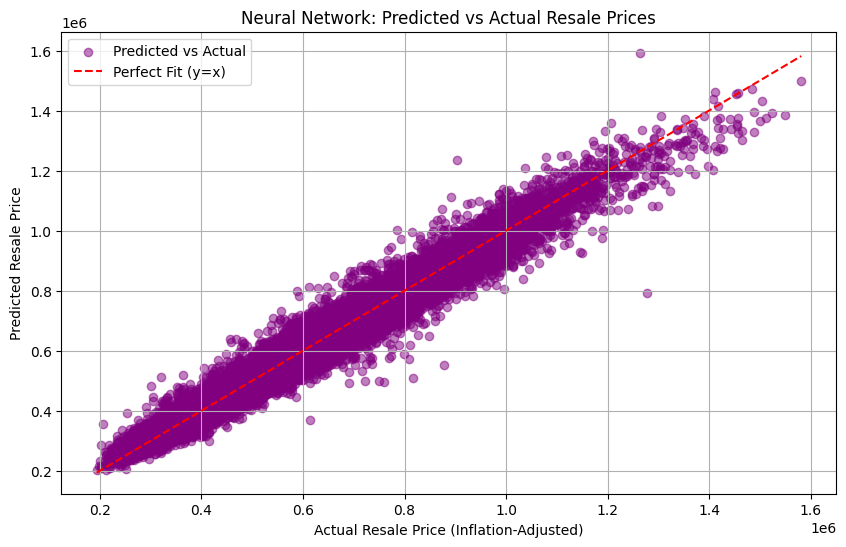

Root Mean Squared Error (RMSE): 33616.97
R-squared (R2): 0.97


In [ ]:
# Plot results
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='purple', label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit (y=x)")
plt.xlabel("Actual Resale Price (Inflation-Adjusted)")
plt.ylabel("Predicted Resale Price")
plt.title("Neural Network: Predicted vs Actual Resale Prices")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")